In [2]:
# Importing libraries. 
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
# To avoid non-essential warnings 
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models 
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_dir = 'dataset/dataset/'
classes = os.listdir(data_dir)

In [4]:
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])


In [5]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

Size of training dataset : 6270


In [6]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

torch.Size([3, 112, 112])


In [7]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))
    plt.show()

Label:  ailurus-fulgens (5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


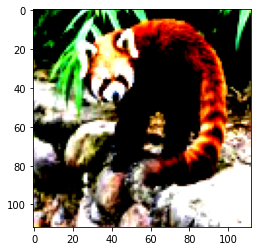

In [8]:
show_image(*dataset[200])

In [9]:
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [10]:
# Random Splitting. 
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds),len(test_ds)  

(5330, 313, 627)

In [11]:
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


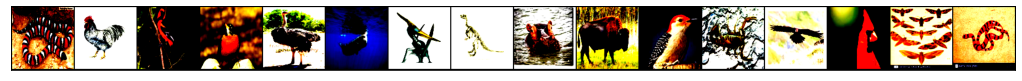

In [12]:
# Multiple images preview. 
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    plt.show()
    break

In [13]:
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return None
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device = get_default_device()
device
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [16]:
input_size = 3*112*112
output_size = 151

In [17]:
# Convolutional Network - Alexnet
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        # Update to match the feature map size for 112x112 input
        self.fc1 = nn.Linear(256 * 2 * 2, 4096)  # Adjusted based on output feature map
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, kernel_size=3, stride=2)

        x = x.view(-1, 256 * 2 * 2)  # Adjusted to match the feature map size
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.1)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, p=0.1)
        x = self.fc3(x)
        
        return F.log_softmax(x, dim=1)

In [18]:
# Model print
num_classes = 151
model = ConvolutionalNetwork(num_classes)
model.cuda()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=151, bias=True)
)

In [19]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

ConvolutionalNetwork(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=151, bias=True)
)

In [20]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [21]:
model = to_device(model, device)

In [22]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 5.017477512359619, 'val_acc': 0.03055555559694767}]

In [23]:
print(test_size)
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.001

627


In [24]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 5.0168, val_loss: 4.9923, val_acc: 0.0344


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.8901, val_loss: 4.7932, val_acc: 0.0656


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 4.7659, val_loss: 4.6901, val_acc: 0.0524


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 4.5847, val_loss: 4.6237, val_acc: 0.0979


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 4.4457, val_loss: 4.6350, val_acc: 0.0861


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 4.3570, val_loss: 4.4194, val_acc: 0.1135


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 4.2373, val_loss: 4.3644, val_acc: 0.1854


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 4.1610, val_loss: 4.3273, val_acc: 0.1486


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 4.0544, val_loss: 4.2765, val_acc: 0.1729


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 3.9652, val_loss: 4.2574, val_acc: 0.2035


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 3.8660, val_loss: 4.2346, val_acc: 0.1705


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 3.7472, val_loss: 4.3382, val_acc: 0.1674


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 3.6252, val_loss: 4.4938, val_acc: 0.1722


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 3.5106, val_loss: 4.4224, val_acc: 0.1524


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 3.3808, val_loss: 4.9116, val_acc: 0.1823


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 3.2483, val_loss: 4.5920, val_acc: 0.1785


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 3.0496, val_loss: 4.9623, val_acc: 0.1885


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 2.9086, val_loss: 5.3746, val_acc: 0.2059


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 2.7560, val_loss: 5.3493, val_acc: 0.1767


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 2.5491, val_loss: 5.7467, val_acc: 0.1688


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [20], train_loss: 2.3709, val_loss: 5.7372, val_acc: 0.2146


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [21], train_loss: 2.1982, val_loss: 6.4090, val_acc: 0.2128


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [22], train_loss: 1.9583, val_loss: 7.1866, val_acc: 0.1979


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [23], train_loss: 1.7888, val_loss: 7.0784, val_acc: 0.1830


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [24], train_loss: 1.6441, val_loss: 7.9587, val_acc: 0.1618


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [25], train_loss: 1.4956, val_loss: 8.4135, val_acc: 0.1431


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [26], train_loss: 1.3787, val_loss: 8.4562, val_acc: 0.1455


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [27], train_loss: 1.3121, val_loss: 9.4715, val_acc: 0.1330


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [28], train_loss: 1.2839, val_loss: 9.6071, val_acc: 0.1531


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [29], train_loss: 1.0919, val_loss: 9.9951, val_acc: 0.1611


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.9242, val_loss: 9.8387, val_acc: 0.1556


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.9746, val_loss: 11.2438, val_acc: 0.1187


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.7720, val_loss: 11.1350, val_acc: 0.1705


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.8177, val_loss: 11.2472, val_acc: 0.1642


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.6928, val_loss: 11.2854, val_acc: 0.1729


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.6966, val_loss: 12.9689, val_acc: 0.1486


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.6177, val_loss: 12.6137, val_acc: 0.1549


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.6522, val_loss: 12.5356, val_acc: 0.1424


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.7116, val_loss: 12.5570, val_acc: 0.1767


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.7861, val_loss: 12.2293, val_acc: 0.1736


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.5718, val_loss: 11.9261, val_acc: 0.1792


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.5915, val_loss: 12.7662, val_acc: 0.1299


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.5946, val_loss: 13.0186, val_acc: 0.1354


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.5742, val_loss: 12.3721, val_acc: 0.1337


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.6420, val_loss: 14.3222, val_acc: 0.1431


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.5385, val_loss: 13.6905, val_acc: 0.1517


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.4975, val_loss: 13.5207, val_acc: 0.1622


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.5819, val_loss: 15.1232, val_acc: 0.1712


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.4881, val_loss: 15.6669, val_acc: 0.1337


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.3707, val_loss: 14.8943, val_acc: 0.1736


In [25]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()
    
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

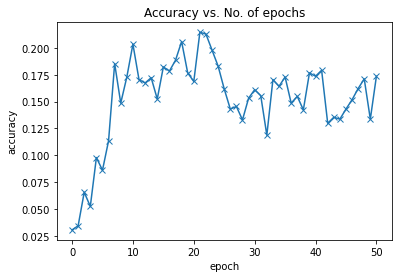

In [26]:
plot_accuracies(history)

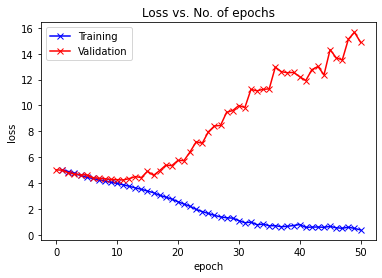

In [27]:
plot_losses(history)

In [28]:
evaluate(model, test_loader)

{'val_loss': 13.686545372009277, 'val_acc': 0.15625}

In [29]:

# shufflenet_v2_x0_5 
from torchvision import datasets, transforms, models

class shufflenet_v2_x0_5(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.shufflenet_v2_x0_5(pretrained=True)  
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

    
# Initialize the model
num_classes = 151  # Assuming 151 classes
model = shufflenet_v2_x0_5(num_classes)

model = to_device(model, device)
history=[evaluate(model, val_loader)]
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.001
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)



  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 3.9446, val_loss: 2.7584, val_acc: 0.5278


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 2.2917, val_loss: 2.2422, val_acc: 0.6434


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.6379, val_loss: 1.9435, val_acc: 0.6750


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.2948, val_loss: 1.8990, val_acc: 0.7163


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.0241, val_loss: 1.7989, val_acc: 0.7302


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.8415, val_loss: 1.8046, val_acc: 0.7521


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.7169, val_loss: 1.8371, val_acc: 0.7451


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.5735, val_loss: 1.8716, val_acc: 0.7764


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.4774, val_loss: 1.8731, val_acc: 0.7639


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.3992, val_loss: 2.0631, val_acc: 0.7413


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.4174, val_loss: 2.0918, val_acc: 0.7576


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.3289, val_loss: 2.1732, val_acc: 0.7420


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.2701, val_loss: 2.0369, val_acc: 0.7569


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.2641, val_loss: 2.2240, val_acc: 0.7382


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.3022, val_loss: 2.3423, val_acc: 0.7326


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.2749, val_loss: 2.2010, val_acc: 0.7420


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.2127, val_loss: 2.4358, val_acc: 0.7389


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.2210, val_loss: 2.3748, val_acc: 0.7420


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.2127, val_loss: 2.3587, val_acc: 0.7514


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.2030, val_loss: 2.2861, val_acc: 0.7451


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.2306, val_loss: 2.4904, val_acc: 0.7139


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.2284, val_loss: 2.3574, val_acc: 0.7670


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.2184, val_loss: 2.3422, val_acc: 0.7608


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.1692, val_loss: 2.4028, val_acc: 0.7326


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.1686, val_loss: 2.5017, val_acc: 0.7351


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.2338, val_loss: 2.3304, val_acc: 0.7569


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.1843, val_loss: 2.5019, val_acc: 0.7326


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.1348, val_loss: 2.3863, val_acc: 0.7670


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.1952, val_loss: 2.7626, val_acc: 0.7271


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.2303, val_loss: 2.3147, val_acc: 0.7757


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.1456, val_loss: 2.5086, val_acc: 0.7420


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.1183, val_loss: 2.4054, val_acc: 0.7733


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.1858, val_loss: 2.7908, val_acc: 0.7302


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.1282, val_loss: 2.4900, val_acc: 0.7420


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.1105, val_loss: 2.5101, val_acc: 0.7420


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.1598, val_loss: 2.3843, val_acc: 0.7608


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.1574, val_loss: 2.3237, val_acc: 0.7608


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.2047, val_loss: 2.5344, val_acc: 0.7319


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.1360, val_loss: 2.5916, val_acc: 0.7420


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.0962, val_loss: 2.4383, val_acc: 0.7451


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.1231, val_loss: 2.4073, val_acc: 0.7726


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.1386, val_loss: 2.5337, val_acc: 0.7545


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.1557, val_loss: 2.8681, val_acc: 0.7302


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.1476, val_loss: 2.6296, val_acc: 0.7420


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.0980, val_loss: 2.4998, val_acc: 0.7351


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.0877, val_loss: 2.6196, val_acc: 0.7413


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.1534, val_loss: 2.7687, val_acc: 0.7233


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.1045, val_loss: 2.5782, val_acc: 0.7420


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.0988, val_loss: 2.5449, val_acc: 0.7639


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.1025, val_loss: 2.5199, val_acc: 0.7608


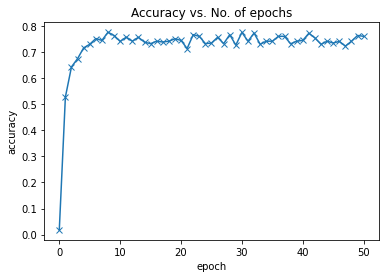

In [30]:
plot_accuracies(history)

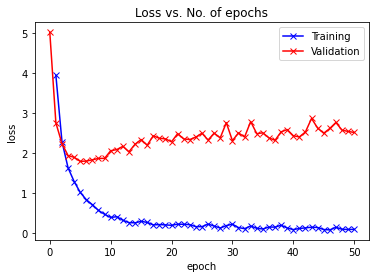

In [31]:
plot_losses(history)

In [32]:
evaluate(model, test_loader)

{'val_loss': 2.8879661560058594, 'val_acc': 0.7276042103767395}

In [33]:
# 2. Resnet18   val_acc': 0.5848

from torchvision import datasets, transforms, models

class ResNetWithCustomMethods(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

# Initialize the model
num_classes = 151  # Assuming 151 classes
model = ResNetWithCustomMethods(num_classes)

model = to_device(model, device)
history=[evaluate(model, val_loader)]
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.001
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 4.2843, val_loss: 4.3496, val_acc: 0.2747


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 3.1078, val_loss: 3.7911, val_acc: 0.3597


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 2.3747, val_loss: 3.1595, val_acc: 0.4583


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 1.7926, val_loss: 2.9539, val_acc: 0.5302


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 1.3003, val_loss: 3.3157, val_acc: 0.5253


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.8439, val_loss: 2.9284, val_acc: 0.6076


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.5769, val_loss: 3.2800, val_acc: 0.5639


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.4964, val_loss: 3.2312, val_acc: 0.5795


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.4345, val_loss: 2.8760, val_acc: 0.6528


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.3290, val_loss: 3.3456, val_acc: 0.5858


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.2643, val_loss: 3.1912, val_acc: 0.6073


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.3395, val_loss: 3.4751, val_acc: 0.6146


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.2661, val_loss: 3.7411, val_acc: 0.6139


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.2475, val_loss: 3.6106, val_acc: 0.6292


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.1966, val_loss: 3.8997, val_acc: 0.5896


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.2962, val_loss: 3.8385, val_acc: 0.5872


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.2225, val_loss: 3.7387, val_acc: 0.6309


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.1508, val_loss: 4.0573, val_acc: 0.5715


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.1877, val_loss: 4.2181, val_acc: 0.5708


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.2009, val_loss: 4.3051, val_acc: 0.5826


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.2223, val_loss: 4.4237, val_acc: 0.5458


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.1947, val_loss: 4.0899, val_acc: 0.5983


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.1284, val_loss: 3.9963, val_acc: 0.6122


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.2211, val_loss: 4.0996, val_acc: 0.5653


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.1836, val_loss: 4.4446, val_acc: 0.5896


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.1332, val_loss: 4.3763, val_acc: 0.5771


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.1243, val_loss: 4.1802, val_acc: 0.5833


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.1587, val_loss: 3.8094, val_acc: 0.6347


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.1862, val_loss: 4.6038, val_acc: 0.5802


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.1209, val_loss: 4.2831, val_acc: 0.6271


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.1181, val_loss: 4.3969, val_acc: 0.5920


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.0961, val_loss: 4.0660, val_acc: 0.5965


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.1364, val_loss: 4.6538, val_acc: 0.5628


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.1312, val_loss: 4.2780, val_acc: 0.5660


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.1116, val_loss: 4.1508, val_acc: 0.6045


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.1156, val_loss: 4.8189, val_acc: 0.5521


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.0915, val_loss: 4.3787, val_acc: 0.5997


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.1117, val_loss: 4.3754, val_acc: 0.5778


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.0879, val_loss: 4.9877, val_acc: 0.5372


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.1284, val_loss: 4.9853, val_acc: 0.5507


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.1036, val_loss: 4.2620, val_acc: 0.5639


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.0741, val_loss: 4.7948, val_acc: 0.5552


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.1544, val_loss: 5.3923, val_acc: 0.5083


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.1250, val_loss: 4.3723, val_acc: 0.5934


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.1446, val_loss: 4.3180, val_acc: 0.6208


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.0958, val_loss: 4.3950, val_acc: 0.6177


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.0437, val_loss: 4.4759, val_acc: 0.5958


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.0636, val_loss: 4.4206, val_acc: 0.5889


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.1191, val_loss: 4.8081, val_acc: 0.5458


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.0806, val_loss: 4.7336, val_acc: 0.5528


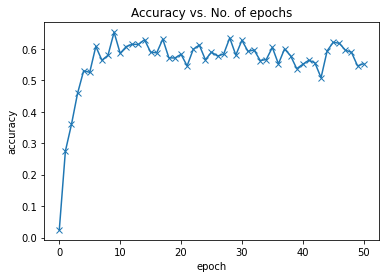

In [34]:
plot_accuracies(history)

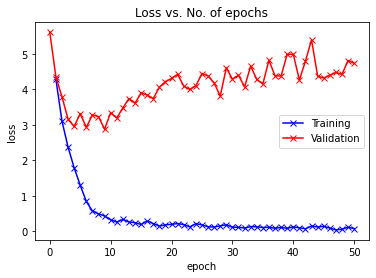

In [35]:
plot_losses(history)

In [36]:
evaluate(model, test_loader)

{'val_loss': 4.510768890380859, 'val_acc': 0.5947917103767395}

In [37]:
# 3.SGD  'val_acc': 0.89062

model = ResNetWithCustomMethods(num_classes)

model = to_device(model, device)
history=[evaluate(model, val_loader)]
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.001
opt_func = torch.optim.SGD
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 5.0185, val_loss: 4.7602, val_acc: 0.1063


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.4556, val_loss: 4.2174, val_acc: 0.2510


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.9496, val_loss: 3.7399, val_acc: 0.4184


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.4940, val_loss: 3.3489, val_acc: 0.5146


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.1292, val_loss: 3.0364, val_acc: 0.6028


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.8003, val_loss: 2.6828, val_acc: 0.6458


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.5176, val_loss: 2.4816, val_acc: 0.6851


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.2793, val_loss: 2.2745, val_acc: 0.7382


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 2.0820, val_loss: 2.0921, val_acc: 0.7444


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.8840, val_loss: 2.0023, val_acc: 0.7719


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.7276, val_loss: 1.8795, val_acc: 0.7719


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 1.5767, val_loss: 1.7491, val_acc: 0.7937


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 1.4435, val_loss: 1.6612, val_acc: 0.8063


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 1.3352, val_loss: 1.5826, val_acc: 0.8406


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 1.2277, val_loss: 1.5409, val_acc: 0.8188


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 1.1434, val_loss: 1.4586, val_acc: 0.8406


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 1.0427, val_loss: 1.4462, val_acc: 0.8313


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.9778, val_loss: 1.3721, val_acc: 0.8562


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.9062, val_loss: 1.3605, val_acc: 0.8500


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.8380, val_loss: 1.2991, val_acc: 0.8531


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.7804, val_loss: 1.2964, val_acc: 0.8531


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.7277, val_loss: 1.2707, val_acc: 0.8656


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.6678, val_loss: 1.2407, val_acc: 0.8531


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.6325, val_loss: 1.2128, val_acc: 0.8719


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.5907, val_loss: 1.2328, val_acc: 0.8594


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.5552, val_loss: 1.1940, val_acc: 0.8750


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.5133, val_loss: 1.1619, val_acc: 0.8750


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.4724, val_loss: 1.1704, val_acc: 0.8656


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.4482, val_loss: 1.1607, val_acc: 0.8750


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.4255, val_loss: 1.1502, val_acc: 0.8844


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.4026, val_loss: 1.1743, val_acc: 0.8781


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.3745, val_loss: 1.1506, val_acc: 0.8688


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.3510, val_loss: 1.1396, val_acc: 0.8813


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.3345, val_loss: 1.1064, val_acc: 0.8813


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.3029, val_loss: 1.1026, val_acc: 0.8750


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.2979, val_loss: 1.1198, val_acc: 0.8656


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.2829, val_loss: 1.0905, val_acc: 0.8781


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.2611, val_loss: 1.1053, val_acc: 0.8625


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.2417, val_loss: 1.0920, val_acc: 0.8625


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.2347, val_loss: 1.1036, val_acc: 0.8813


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.2244, val_loss: 1.0573, val_acc: 0.8750


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.2181, val_loss: 1.0894, val_acc: 0.8750


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.2051, val_loss: 1.0918, val_acc: 0.8781


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.1894, val_loss: 1.0719, val_acc: 0.8938


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.1854, val_loss: 1.0651, val_acc: 0.8813


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.1773, val_loss: 1.0711, val_acc: 0.8844


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.1660, val_loss: 1.0792, val_acc: 0.8781


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.1578, val_loss: 1.0618, val_acc: 0.8719


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.1529, val_loss: 1.0584, val_acc: 0.8938


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.1529, val_loss: 1.0569, val_acc: 0.8688


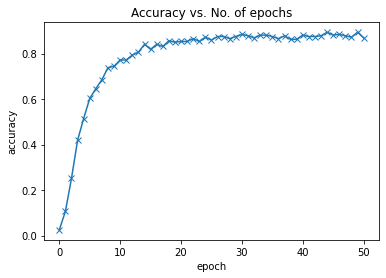

In [38]:
plot_accuracies(history)

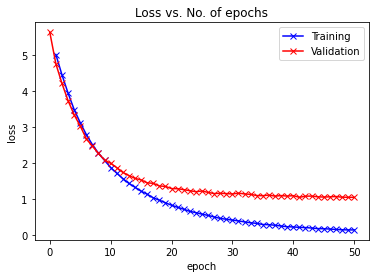

In [39]:
plot_losses(history)

In [40]:
evaluate(model, test_loader)

{'val_loss': 0.9783399701118469, 'val_acc': 0.8932291865348816}

In [41]:
# Adding data augmentation      val_acc': 0.7682

# Data Augmentation
train_transform = transforms.Compose([
    transforms.Resize(112),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#     transforms.RandomCrop(112, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.488,), (0.2172,))
])

dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset:', len(dataset))

# Random Splitting.
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
print(len(train_ds), len(val_ds), len(test_ds))

batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

device = get_default_device()
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)


Size of training dataset: 6270
5330 313 627


In [42]:
num_classes = 151
model = ResNetWithCustomMethods(num_classes)
model.cuda()

model = to_device(model, device)
history=[evaluate(model, val_loader)]
history

[{'val_loss': 5.634512424468994, 'val_acc': 0.012500000186264515}]

In [43]:
print(test_size)
num_epochs = 50
opt_func = torch.optim.SGD
lr = 0.001

history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


627


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 5.0170, val_loss: 4.7502, val_acc: 0.1111


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.4259, val_loss: 4.2290, val_acc: 0.2785


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.9272, val_loss: 3.7426, val_acc: 0.3865


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.4948, val_loss: 3.3339, val_acc: 0.5264


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.1108, val_loss: 2.9740, val_acc: 0.5795


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.7946, val_loss: 2.7422, val_acc: 0.6552


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.5383, val_loss: 2.4995, val_acc: 0.6826


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.3001, val_loss: 2.3301, val_acc: 0.7194


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 2.0884, val_loss: 2.1588, val_acc: 0.7726


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.8934, val_loss: 2.0293, val_acc: 0.7601


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.7463, val_loss: 1.8796, val_acc: 0.7913


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 1.6042, val_loss: 1.7879, val_acc: 0.7976


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 1.4767, val_loss: 1.7203, val_acc: 0.7851


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 1.3626, val_loss: 1.6491, val_acc: 0.8132


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 1.2507, val_loss: 1.5731, val_acc: 0.8132


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 1.1585, val_loss: 1.4575, val_acc: 0.8444


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 1.0843, val_loss: 1.4363, val_acc: 0.8444


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 1.0061, val_loss: 1.3723, val_acc: 0.8538


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.9339, val_loss: 1.3737, val_acc: 0.8476


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.8676, val_loss: 1.3223, val_acc: 0.8507


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.7904, val_loss: 1.2588, val_acc: 0.8601


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.7492, val_loss: 1.2544, val_acc: 0.8694


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.6977, val_loss: 1.2004, val_acc: 0.8694


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.6624, val_loss: 1.2037, val_acc: 0.8726


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.6073, val_loss: 1.1825, val_acc: 0.8757


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.5658, val_loss: 1.1587, val_acc: 0.8851


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.5269, val_loss: 1.1328, val_acc: 0.8882


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.4978, val_loss: 1.1303, val_acc: 0.8813


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.4656, val_loss: 1.1114, val_acc: 0.8694


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.4327, val_loss: 1.1286, val_acc: 0.8875


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.4000, val_loss: 1.0975, val_acc: 0.8938


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.3844, val_loss: 1.0698, val_acc: 0.8882


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.3659, val_loss: 1.0914, val_acc: 0.8844


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.3374, val_loss: 1.0574, val_acc: 0.8969


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.3183, val_loss: 1.0656, val_acc: 0.8969


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.3086, val_loss: 1.0831, val_acc: 0.8813


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.2834, val_loss: 1.0325, val_acc: 0.8813


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.2746, val_loss: 1.0557, val_acc: 0.8969


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.2550, val_loss: 1.0953, val_acc: 0.8906


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.2398, val_loss: 1.0235, val_acc: 0.9062


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.2283, val_loss: 1.0347, val_acc: 0.8969


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.2207, val_loss: 1.0688, val_acc: 0.8938


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.2088, val_loss: 1.0449, val_acc: 0.8938


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.2001, val_loss: 1.0230, val_acc: 0.8969


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.1900, val_loss: 1.0503, val_acc: 0.8969


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.1807, val_loss: 0.9928, val_acc: 0.8969


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.1736, val_loss: 1.0041, val_acc: 0.9125


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.1617, val_loss: 1.0190, val_acc: 0.8938


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.1612, val_loss: 1.0113, val_acc: 0.8969


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.1509, val_loss: 0.9942, val_acc: 0.8944


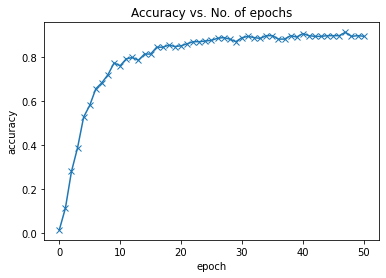

In [44]:
plot_accuracies(history)


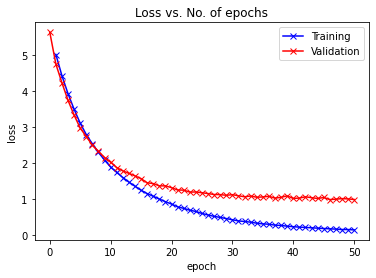

In [45]:
plot_losses(history)

In [46]:
evaluate(model, test_loader)

{'val_loss': 0.7483908534049988, 'val_acc': 0.917187511920929}

In [47]:
#  4. Changing the loss function  Focal loss   'val_acc': 0.9151   

class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)
            input = input.transpose(1, 2)
            input = input.contiguous().view(-1, input.size(2))
        target = target.view(-1, 1)

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1, target)
        logpt = logpt.view(-1)
        pt = logpt.exp()

        if self.alpha is not None:
            if self.alpha.type() != input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0, target.data.view(-1))
            logpt = logpt * at

        loss = -1 * (1 - pt) ** self.gamma * logpt
        if self.size_average:
            return loss.mean()
        else:
            return loss.sum()

criterion = FocalLoss(gamma=4.5)
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = criterion(out, labels)       # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = criterion(out, labels)         # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

model = ResNetWithCustomMethods(num_classes)
model.cuda()

model = to_device(model, device)
history=[evaluate(model, val_loader)]
num_epochs = 50 
opt_func = torch.optim.SGD
lr = 0.001

history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 5.0423, val_loss: 4.7150, val_acc: 0.1156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 4.4648, val_loss: 4.2328, val_acc: 0.2691


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.9820, val_loss: 3.7624, val_acc: 0.3771


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 3.5487, val_loss: 3.3111, val_acc: 0.5052


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 3.1696, val_loss: 3.0325, val_acc: 0.5990


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.8476, val_loss: 2.8061, val_acc: 0.6427


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 2.5792, val_loss: 2.5722, val_acc: 0.6983


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 2.3228, val_loss: 2.2962, val_acc: 0.7389


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 2.1141, val_loss: 2.2024, val_acc: 0.7514


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.9222, val_loss: 1.9990, val_acc: 0.7819


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 1.7462, val_loss: 1.9334, val_acc: 0.7944


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 1.6052, val_loss: 1.7777, val_acc: 0.8038


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 1.4788, val_loss: 1.6735, val_acc: 0.8319


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 1.3627, val_loss: 1.6369, val_acc: 0.8281


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 1.2539, val_loss: 1.5595, val_acc: 0.8375


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 1.1553, val_loss: 1.5070, val_acc: 0.8507


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 1.0735, val_loss: 1.4287, val_acc: 0.8625


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.9995, val_loss: 1.4251, val_acc: 0.8531


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.9176, val_loss: 1.3493, val_acc: 0.8719


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.8676, val_loss: 1.3440, val_acc: 0.8594


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.7928, val_loss: 1.3114, val_acc: 0.8656


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.7510, val_loss: 1.2822, val_acc: 0.8594


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.6861, val_loss: 1.2264, val_acc: 0.8719


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.6434, val_loss: 1.2377, val_acc: 0.8688


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.6028, val_loss: 1.2143, val_acc: 0.8813


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.5516, val_loss: 1.1748, val_acc: 0.8781


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.5275, val_loss: 1.1569, val_acc: 0.8781


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.4927, val_loss: 1.1393, val_acc: 0.8813


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.4521, val_loss: 1.1334, val_acc: 0.8719


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.4320, val_loss: 1.1262, val_acc: 0.8844


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.4046, val_loss: 1.1223, val_acc: 0.8781


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.3717, val_loss: 1.1051, val_acc: 0.8813


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.3570, val_loss: 1.0921, val_acc: 0.8875


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.3332, val_loss: 1.1022, val_acc: 0.8781


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.3127, val_loss: 1.1001, val_acc: 0.8844


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.2976, val_loss: 1.0863, val_acc: 0.8781


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.2837, val_loss: 1.0851, val_acc: 0.8813


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.2611, val_loss: 1.0884, val_acc: 0.8813


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.2510, val_loss: 1.0638, val_acc: 0.8813


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.2348, val_loss: 1.0837, val_acc: 0.8719


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.2325, val_loss: 1.0741, val_acc: 0.8719


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.2173, val_loss: 1.0583, val_acc: 0.8844


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.2026, val_loss: 1.0459, val_acc: 0.8906


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.1985, val_loss: 1.0566, val_acc: 0.8750


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.1848, val_loss: 1.0435, val_acc: 0.8750


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.1749, val_loss: 1.0614, val_acc: 0.8750


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.1718, val_loss: 1.0418, val_acc: 0.8719


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.1594, val_loss: 1.0194, val_acc: 0.8875


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.1560, val_loss: 1.0383, val_acc: 0.8719


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.1534, val_loss: 1.0432, val_acc: 0.8844


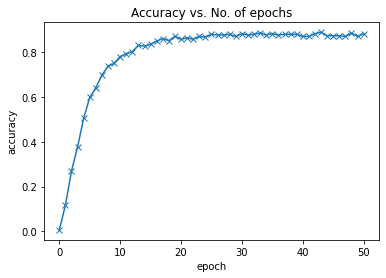

In [48]:
plot_accuracies(history)



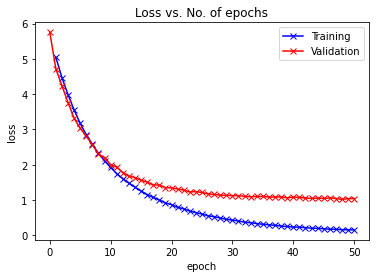

In [49]:
plot_losses(history)

In [50]:
evaluate(model, test_loader)

{'val_loss': 0.7481414079666138, 'val_acc': 0.9140625}

In [57]:
from torchvision import datasets, transforms, models

class shufflenet_v2_x0_5(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.shufflenet_v2_x0_5(pretrained=True)  
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

    
# Initialize the model
num_classes = 151  # Assuming 151 classes
model = shufflenet_v2_x0_5(num_classes)

model = to_device(model, device)
history=[evaluate(model, val_loader)]
num_epochs = 50
opt_func = torch.optim.Adam
lr = 0.001
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)



  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 3.5670, val_loss: 2.0463, val_acc: 0.5670


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 1.6308, val_loss: 1.5564, val_acc: 0.6465


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 1.0407, val_loss: 1.3730, val_acc: 0.7045


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.7940, val_loss: 1.2293, val_acc: 0.7413


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.5527, val_loss: 1.1992, val_acc: 0.7514


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.4406, val_loss: 1.2780, val_acc: 0.7108


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.3572, val_loss: 1.2703, val_acc: 0.7413


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.2888, val_loss: 1.2534, val_acc: 0.7233


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.2309, val_loss: 1.2740, val_acc: 0.7639


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.2171, val_loss: 1.2945, val_acc: 0.7507


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.1723, val_loss: 1.2076, val_acc: 0.7608


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.1787, val_loss: 1.3479, val_acc: 0.7233


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.1586, val_loss: 1.2538, val_acc: 0.7646


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.1718, val_loss: 1.3278, val_acc: 0.7576


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.1379, val_loss: 1.4281, val_acc: 0.7319


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.1403, val_loss: 1.3983, val_acc: 0.7420


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.1278, val_loss: 1.4242, val_acc: 0.7507


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.1196, val_loss: 1.2549, val_acc: 0.7694


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.1234, val_loss: 1.3779, val_acc: 0.7295


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.1195, val_loss: 1.3203, val_acc: 0.7382


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.1102, val_loss: 1.4665, val_acc: 0.7132


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.1166, val_loss: 1.5222, val_acc: 0.7201


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.1135, val_loss: 1.4456, val_acc: 0.7420


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.1226, val_loss: 1.4103, val_acc: 0.7264


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.1077, val_loss: 1.4988, val_acc: 0.7476


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.1060, val_loss: 1.5305, val_acc: 0.7295


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.0924, val_loss: 1.4098, val_acc: 0.7396


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.0861, val_loss: 1.4677, val_acc: 0.7420


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.0873, val_loss: 1.4942, val_acc: 0.7045


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.0853, val_loss: 1.4314, val_acc: 0.7226


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.0870, val_loss: 1.5758, val_acc: 0.7226


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.0895, val_loss: 1.3192, val_acc: 0.7764


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.0769, val_loss: 1.3036, val_acc: 0.7476


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.0718, val_loss: 1.4201, val_acc: 0.7351


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.0823, val_loss: 1.4845, val_acc: 0.7264


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.0840, val_loss: 1.4053, val_acc: 0.7326


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.0987, val_loss: 1.3559, val_acc: 0.7569


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.0967, val_loss: 1.3181, val_acc: 0.7601


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.0769, val_loss: 1.3655, val_acc: 0.7601


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.0581, val_loss: 1.5380, val_acc: 0.7319


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.0639, val_loss: 1.5345, val_acc: 0.7163


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.0938, val_loss: 1.3940, val_acc: 0.7295


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.0796, val_loss: 1.4635, val_acc: 0.7444


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.0712, val_loss: 1.3538, val_acc: 0.7382


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.0531, val_loss: 1.4055, val_acc: 0.7514


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.0664, val_loss: 1.2812, val_acc: 0.7507


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.0738, val_loss: 1.4554, val_acc: 0.7319


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.0623, val_loss: 1.4936, val_acc: 0.7444


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.0573, val_loss: 1.3753, val_acc: 0.7358


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.0554, val_loss: 1.4201, val_acc: 0.7413


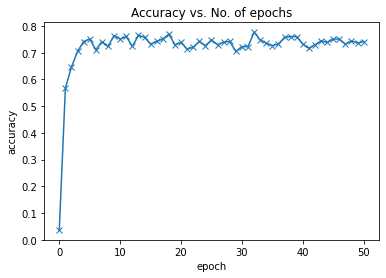

In [58]:
plot_accuracies(history)

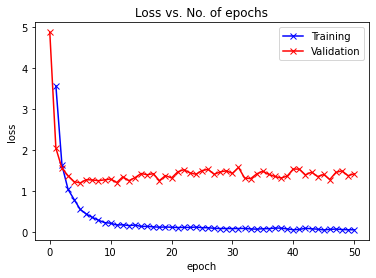

In [59]:
plot_losses(history)

In [60]:
evaluate(model, test_loader)

{'val_loss': 0.6270420551300049, 'val_acc': 0.8765625357627869}